In [2]:
import datetime
import numpy as np
import os 

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
ultrasound_fullname = 'numpy_data/Stacked Arrays/stacked_image_array.npy'
segmentation_fullname = 'numpy_data/Stacked Arrays/stacked_segmentation_array.npy'

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))


Found 24 ultrasound images and 24 segmentations


In [4]:
test_ultrasound_fullname = 'numpy_data/Stacked Arrays/test_image_array.npy'
test_segmentation_fullname = 'numpy_data/Stacked Arrays/test_segmentation_array.npy'

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname)
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))

Reading test ultrasound from: numpy_data/Stacked Arrays/test_image_array.npy
Reading test segmentation from : numpy_data/Stacked Arrays/test_segmentation_array.npy

Found 6 test ultrasound images and 6 segmentations


In [5]:
# Batch Generator

import keras.utils
import scipy.ndimage

max_rotation_angle = 10

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(128, 128, 128),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        
        for i in range(self.batch_size):
            x[i,:,:,:,:] = self.x[batch_indexes[i],:,:,:,:]
            y[i,:,:,:]= self.y[batch_indexes[i],:,:,:]
        
        angle = np.random.randint(-max_rotation_angle, max_rotation_angle)
        # rotate x-axis
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (1,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(y, angle, (1,2), False, mode="constant", cval=0, order=0)
        #rotate y-axis
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (0,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(y, angle, (0,2), False, mode="constant", cval=0, order=0)

        x_rot = np.clip(x_rot, 0.0, 1.0)
        y_rot = np.clip(y_rot, 0.0, 1.0)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)

        return x_rot, y_onehot
        

In [6]:
# Prepare dilated output

def dilateStack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

width = 128
segmentation_dilated = dilateStack(segmentation_data[:, :, :, :, 0], width)

In [7]:
# Uncomment this if you don't want dilation

segmentation_dilated[:, :, :, :] = segmentation_data[:, :, :, :, 0]

In [8]:
num_classes = 2

def nvidia_unet(patch_size=128, num_classes=num_classes):
    input_ = Input((128, 128, 128, 1))
    skips = []
    output = input_
    c = num_classes
    
    for shape, filters in zip([5, 3, 3, 3, 3, 3, 3], [8, 16, 32, 32, 32, 32, 32]):
        skips.append(output)
        #print("pre_skip")
        #print(output)
        #print(shape)
        output= Conv3D(filters, (3, 3, 3), strides=2, padding="same", activation="relu")(output)
        #print("output3d")
        #print(output)
    
    # output = keras.layers.UpSampling3D(size=(1, 2, 2))(output)
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4], [32, 32, 32, 32, 16, 8, 2]):
        #print(output.shape)
        output = keras.layers.UpSampling3D()(output)
        #print("output2.0:")
        #print(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=4)

        if filters != c:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv3D(filters, (3, 3, 3), activation=activation, padding="same")(output)
        if filters != c:
            output = BatchNormalization(momentum=.9)(output)
        
        print(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

model = nvidia_unet(128, num_classes)

# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 2, 2, 2, 32), dtype=float32)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 4, 4, 4, 32), dtype=float32)
Tensor("batch_normalization_3/cond/Merge:0", shape=(?, 8, 8, 8, 32), dtype=float32)
Tensor("batch_normalization_4/cond/Merge:0", shape=(?, 16, 16, 16, 32), dtype=float32)
Tensor("batch_normalization_5/cond/Merge:0", shape=(?, 32, 32, 32, 16), dtype=float32)
Tensor("batch_normalization_6/cond/Merge:0", shape=(?, 64, 64, 64, 8), dtype=float32)
Tensor("conv3d_14/truediv:0", shape=(?, 128, 128, 128, 2), dtype=float32)


In [9]:
print("Model built with {} parameters".format(model.count_params()))

Model built with 376624 parameters


In [10]:
max_learning_rate = 0.01
min_learning_rate = 0.00001
num_epochs = 20

learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss= "binary_crossentropy",
               metrics=["accuracy"])

print("Learning rate decay = {}".format(learning_rate_decay))

Learning rate decay = 0.0004995


In [ ]:
batch_size = 2

training_generator = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_dilated, batch_size)
test_generator = UltrasoundSegmentationBatchGenerator(test_ultrasound_data, test_segmentation_data[:, :, :, :, 0], batch_size)

training_time_start = datetime.datetime.now()

training_log = model.fit_generator(training_generator,
                                   validation_data=test_generator,
                                   epochs=num_epochs,
                                   verbose=1)

Epoch 1/20


In [ ]:
training_time_stop = datetime.datetime.now()
print("Training started at: {}".format(training_time_start))
print("Training stopped at: {}".format(training_time_stop))
print("Total training time: {}".format(training_time_stop-training_time_start))

In [ ]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = 'saved_models'
model_file_name = "model_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model.save(weights_file_path)
print("Model saved to: {}".format(weights_file_path))

In [11]:
trained_model = load_model('saved_models/model_2019-07-12_16-38-23.h5')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [12]:
y_pred = trained_model.predict(test_ultrasound_data)

In [13]:
%matplotlib notebook

In [14]:
# Multi-slice view code extracted and adapted from: https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data
import matplotlib.pyplot as plt

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

(128, 128, 128, 1)


<IPython.core.display.Javascript object>


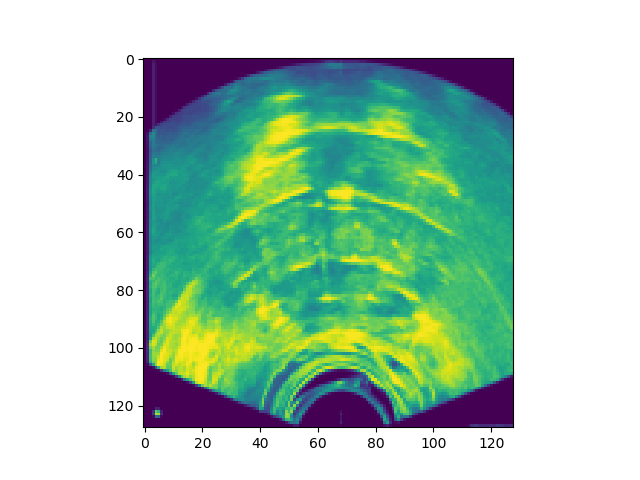

In [15]:
# ultrasound
ultrasound_img = test_ultrasound_data[0]
print(ultrasound_img.shape)
multi_slice_viewer(ultrasound_img[:, :, :, 0])

(128, 128, 128, 1)


<IPython.core.display.Javascript object>


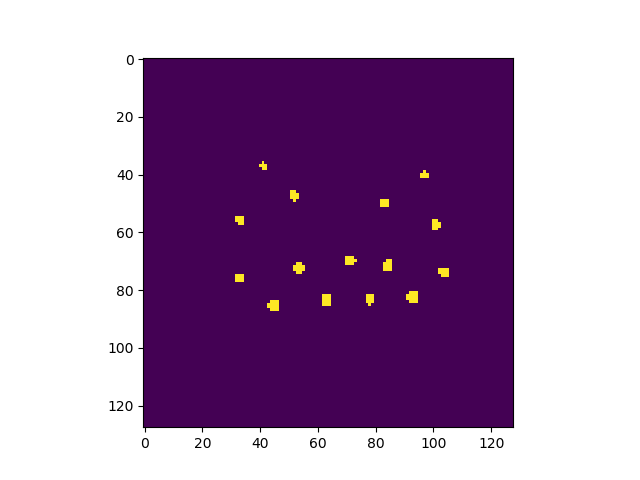

In [16]:
# Segmentation
segmentation_img = test_segmentation_data[0]
print(segmentation_img.shape)
multi_slice_viewer(segmentation_img[:, :, :, 0])

(128, 128, 128, 2)


<IPython.core.display.Javascript object>


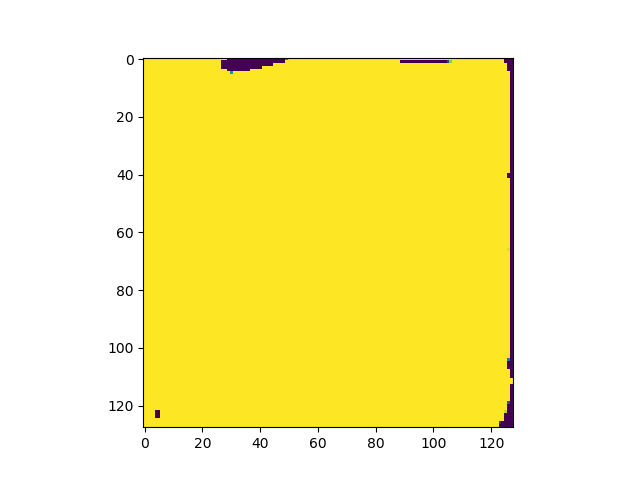

In [17]:
# Prediction
predicted_img = y_pred[0]
print(predicted_img.shape)
multi_slice_viewer(predicted_img[:, :, :, 1])